In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from itertools import tee
import math
import sys
sys.path.append("..") # Adds higher directory to our route_optimization.
from route_optimization.route_optimization_handler import RouteOptimizationHandler

Load the dataset

In [2]:
routes_df = pd.read_csv('../dataset/service_trips.csv', index_col=0)

Create route_optimizer object 

In [3]:
RESTRICTED_TIME = 480
DEADHEAD = 15
route_optimizer = RouteOptimizationHandler(routes_df=routes_df, restricted_time=RESTRICTED_TIME)

Fit the object - generate S and P matrices

In [4]:
%%time
route_optimizer.fit()
S = route_optimizer.get_neighbors_matrix()
P = route_optimizer.get_penalty_matrix()

Wall time: 2min 52s


### Generate random schedule

In [5]:
%%time
s_random = route_optimizer.get_random_schedule()

Wall time: 3min 2s


In [6]:
print('---Random Schedule---')
print(f'Valid Schedule: {route_optimizer._valid_schedule(schedule=s_random)}')
print('OpEx:', route_optimizer.get_schedule_OpEx(s_random))
print('Deadheads:', route_optimizer.get_schedule_OpEx(s_random) / DEADHEAD)
print('Num of Vehicles:', len(s_random))

---Random Schedule---
Valid Schedule: True
OpEx: 4590
Deadheads: 306.0
Num of Vehicles: 131


### Generate schedule using Beam Search

Clearing the covered trips for creating new schedule

In [7]:
route_optimizer.reset_C()

Setting $\beta$ = 10

In [8]:
beta = 10

In [9]:
%%time
s = route_optimizer.get_schedule(k=beta)

New Vehicle created len of 16 Took 955.13s
Covered 3.150% of the trips...
vehicle deadheads 0.0...
vehicle duration 477...
Num of vehicles 1...

New Vehicle created len of 15 Took 829.49s
Covered 6.102% of the trips...
vehicle deadheads 0.0...
vehicle duration 480...
Num of vehicles 2...

New Vehicle created len of 10 Took 394.54s
Covered 8.071% of the trips...
vehicle deadheads 0.0...
vehicle duration 480...
Num of vehicles 3...

New Vehicle created len of 8 Took 290.02s
Covered 9.646% of the trips...
vehicle deadheads 0.0...
vehicle duration 463...
Num of vehicles 4...

New Vehicle created len of 8 Took 274.78s
Covered 11.220% of the trips...
vehicle deadheads 0.0...
vehicle duration 480...
Num of vehicles 5...

New Vehicle created len of 8 Took 280.59s
Covered 12.795% of the trips...
vehicle deadheads 0.0...
vehicle duration 477...
Num of vehicles 6...

New Vehicle created len of 8 Took 296.23s
Covered 14.370% of the trips...
vehicle deadheads 1.0...
vehicle duration 477...
Num of v

New Vehicle created len of 6 Took 6.68s
Covered 79.921% of the trips...
vehicle deadheads 0.0...
vehicle duration 390...
Num of vehicles 58...

New Vehicle created len of 6 Took 5.65s
Covered 81.102% of the trips...
vehicle deadheads 0.0...
vehicle duration 390...
Num of vehicles 59...

New Vehicle created len of 6 Took 5.44s
Covered 82.283% of the trips...
vehicle deadheads 0.0...
vehicle duration 390...
Num of vehicles 60...

New Vehicle created len of 6 Took 5.20s
Covered 83.465% of the trips...
vehicle deadheads 0.0...
vehicle duration 390...
Num of vehicles 61...

New Vehicle created len of 6 Took 5.12s
Covered 84.646% of the trips...
vehicle deadheads 0.0...
vehicle duration 390...
Num of vehicles 62...

New Vehicle created len of 4 Took 3.48s
Covered 85.433% of the trips...
vehicle deadheads 0.0...
vehicle duration 333...
Num of vehicles 63...

New Vehicle created len of 3 Took 2.48s
Covered 86.024% of the trips...
vehicle deadheads 0.0...
vehicle duration 480...
Num of vehicles

In [10]:
print('---Beam Search Schedule---')
print(f'Valid Schedule: {route_optimizer._valid_schedule(schedule=s)}')
print('OpEx:', route_optimizer.get_schedule_OpEx(schedule=s))
print('Deadheads:', route_optimizer.get_schedule_OpEx(schedule=s) / DEADHEAD)
print('Num of Vehicles:', len(s))

---Beam Search Schedule---
Valid Schedule: True
OpEx: 2685
Deadheads: 179.0
Num of Vehicles: 88


### Post HOC

In [11]:
schedules_by_iterations = {0: [[i] for i in routes_df.index]}
for idx,v in enumerate(s):
    last_s = schedules_by_iterations[idx].copy()
    [last_s.remove([trip]) for trip in v]
    last_s.append(v)
    schedules_by_iterations[idx+1] = last_s
    
random_schedules_by_iterations = {0: [[i] for i in routes_df.index]}
for idx,v in enumerate(s_random):
    last_s = random_schedules_by_iterations[idx].copy()
    [last_s.remove([trip]) for trip in v]
    last_s.append(v)
    random_schedules_by_iterations[idx+1] = last_s

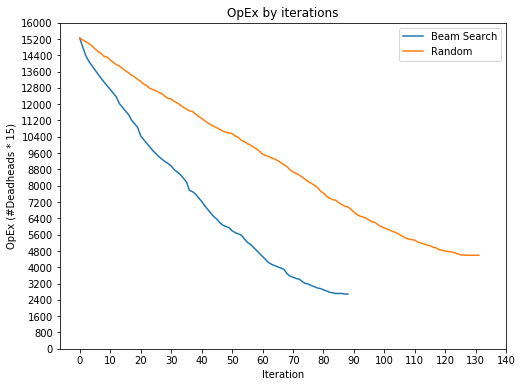

In [12]:
plt.figure(figsize=(8, 6))

x = list(schedules_by_iterations.keys())
y = [route_optimizer.get_schedule_OpEx(schedule=s) for s in schedules_by_iterations.values()]
x_random = list(random_schedules_by_iterations.keys())
y_random = [route_optimizer.get_schedule_OpEx(schedule=s) for s in random_schedules_by_iterations.values()]
plt.plot(x, y, label=r'Beam Search')
plt.plot(x_random, y_random, label=r'Random')
plt.legend(loc='upper right')
plt.ylabel('OpEx (#Deadheads * 15)')
plt.xlabel('Iteration')
plt.xticks(range(0,max(len(x), len(x_random))+10,10))
plt.yticks(np.arange(0, max(y)+800, step=800))
plt.title('OpEx by iterations')
plt.savefig('opex')

plt.show()

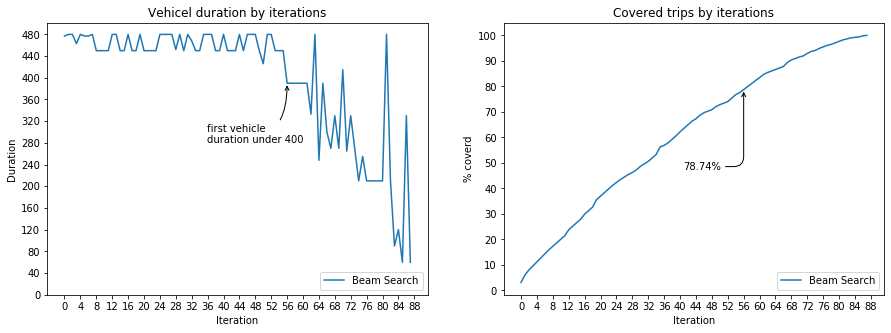

In [15]:
plt.figure(figsize=(15, 5))

x = range(len(s))
y = [route_optimizer._get_vehicle_duration(vehicle=v) for v in s]
plt.subplot(121)
plt.plot(x, y, label=r'Beam Search')

plt.annotate('first vehicle\nduration under 400',
            xy=(56, y[56]), xycoords='data',
            xytext=(-80, -60), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

plt.legend(loc='lower right')
plt.ylabel('Duration')
plt.xlabel('Iteration')
plt.xticks(np.arange(0, len(x)+4, step=4))
plt.yticks(np.arange(0, RESTRICTED_TIME+40, step=40))
plt.title('Vehicel duration by iterations')

x = range(len(s))
y = [100*(len(v) / len(route_optimizer.get_N())) for v in s]
cumulative_y = np.cumsum(y)
plt.subplot(122)
plt.plot(x, cumulative_y, label=r'Beam Search')

plt.annotate(f'{cumulative_y[56]:0.2f}%',
            xy=(56,cumulative_y[56]), xycoords='data',
            xytext=(-60, -80), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=-180,angleB=90,rad=10"))


plt.legend(loc='lower right')
plt.ylabel('% coverd')
plt.xlabel('Iteration')
plt.xticks(np.arange(0, len(x)+4, step=4))
plt.yticks(np.arange(0, 110, step=10))
plt.title('Covered trips by iterations')
plt.savefig('bs weekness')

plt.show()

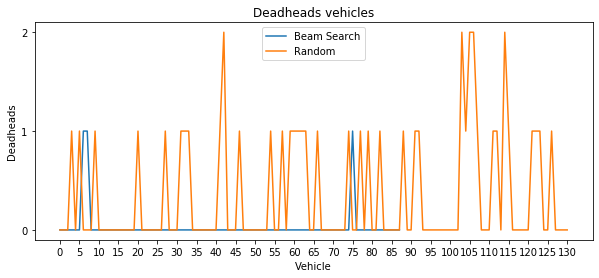

In [53]:
plt.figure(figsize=(10, 4))

x = range(len(s))
y = [route_optimizer._deadhead_duration(vehicle=v)/15 - 2 for v in s]

x_random = range(len(s_random))
y_random = [route_optimizer._deadhead_duration(vehicle=v)/15 - 2 for v in s_random]

plt.plot(x, y, label=r'Beam Search')
plt.plot(x_random, y_random, label=r'Random')

plt.legend(loc='upper center')
plt.ylabel('Deadheads')
plt.xlabel('Vehicle')
plt.xticks(range(0,max(len(x), len(x_random)),5))
plt.yticks(np.arange(0, 3, step=1))
plt.title('Deadheads vehicles')

plt.savefig('deadheads_vehicles')
plt.show()